In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('./combined.csv')

# Find the number of unique items in each column
unique_counts = df.nunique()

unique_items = df['Sensor'].unique()

# Display the results
print(unique_counts)
print(unique_items)

Unnamed: 0    268025
DateTime       17755
Sensor             9
Value              2
Timestamp      10697
dtype: int64
['bathroom_door' 'bathroom_button' 'bathroom_light' nan 'bedroom_light'
 'bedroom_button' 'kitchen_light' 'kitchen_motion' 'living_button'
 'living_light']


In [3]:
from datetime import datetime

def convert_to_seconds(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y %H:%M:%S')
    return int(date_obj.timestamp())

df['seconds_since_epoch'] = df['Timestamp'].apply(convert_to_seconds)
print(df.head())

   Unnamed: 0 DateTime           Sensor  Value            Timestamp  \
0           0  36:22.9    bathroom_door    0.0  12/20/2022 17:36:23   
1           1  36:24.2    bathroom_door    0.0  12/20/2022 17:36:24   
2           2  36:24.2  bathroom_button    0.0  12/20/2022 17:36:24   
3           3  36:24.2    bathroom_door    0.0  12/20/2022 17:36:24   
4           4  36:24.6   bathroom_light    1.0  12/20/2022 17:36:25   

   seconds_since_epoch  
0           1671579383  
1           1671579384  
2           1671579384  
3           1671579384  
4           1671579385  


In [4]:
# Sample the data hourly and get sum of the active sensors on that hourly data

df['date'] = pd.to_datetime(df['Timestamp']) #convert the Timestamp to datetime
df = df.set_index('date') #make the date column as index
df_hourly = df.Value.resample('h').sum() #resample on hourly basis and get summary of sensor values on that hour.
df_minute = df.Value.resample('15min').sum()
# df_hourly.columns = ['date', 'values']
df_hourly = df_hourly.reset_index()
df_minute = df_minute.reset_index()

# new_df = pd.DataFrame(df_hourly, columns=['datetime', 'values'])
print(df_hourly.columns, df_minute.shape)

Index(['date', 'Value'], dtype='object') (2586, 2)


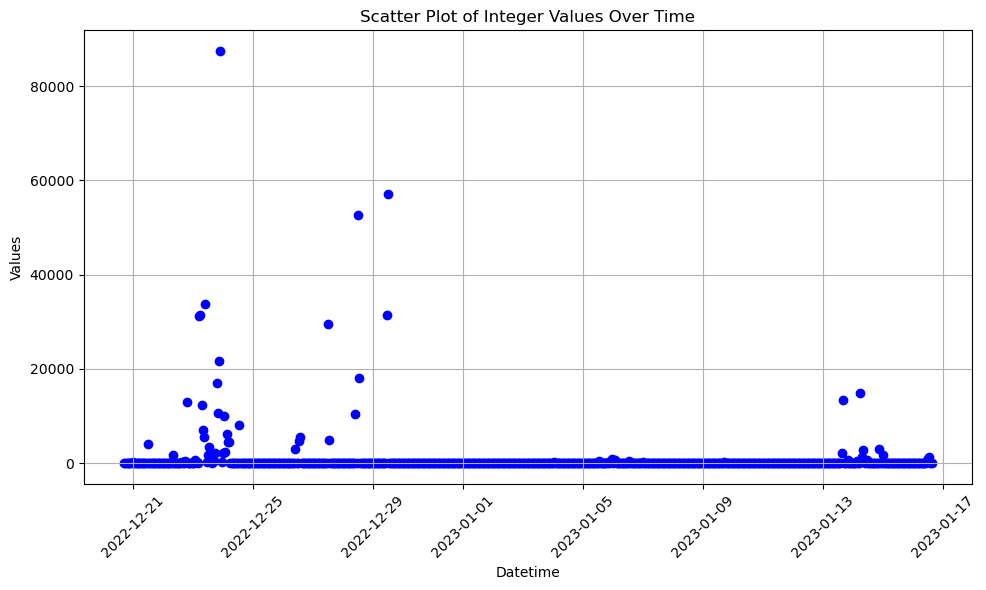

In [23]:

# df_hourly['datetime'] = pd.to_datetime(df_hourly['date'])
plt.figure(figsize=(10, 6))
plt.scatter(df_hourly['date'], df_hourly['Value'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

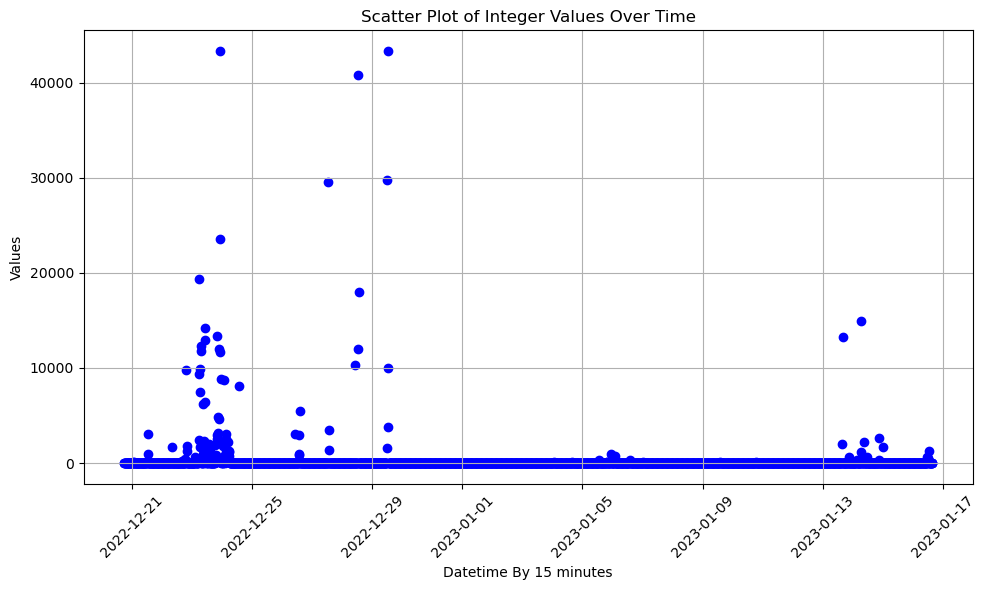

In [5]:
# df_hourly['datetime'] = pd.to_datetime(df_hourly['date'])
plt.figure(figsize=(10, 6))
plt.scatter(df_minute['date'], df_minute['Value'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime By 15 minutes')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

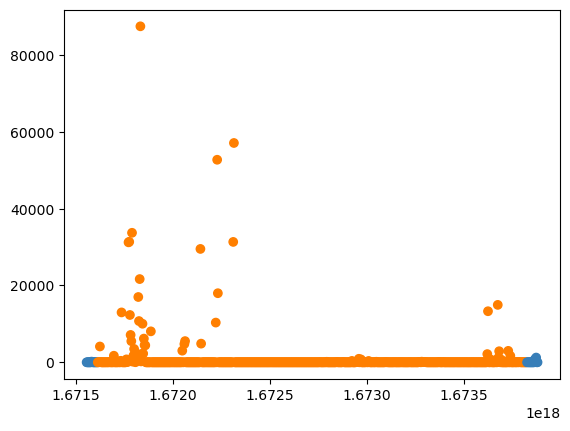

In [24]:
# Fit the model 
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

df_hourly['date'] = df_hourly['date'].values.astype("float64")
df_hourly['Value'] = df_hourly['Value'].values.astype("float64")

clf = LocalOutlierFactor(n_neighbors=30, contamination=0.05) 
y_pred = clf.fit_predict(df_hourly) 
# Generate colors based on the prediction
colors = np.array(['#377eb8', '#ff7f00']) 
plt.scatter(df_hourly['date'], df_hourly['Value'], color=colors[(y_pred + 1) // 2])

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


{0: 66, 1: 68, 2: 58, 3: 69, 4: 62, 5: 67, 6: 63, 7: 69, 8: 59, 9: 66}


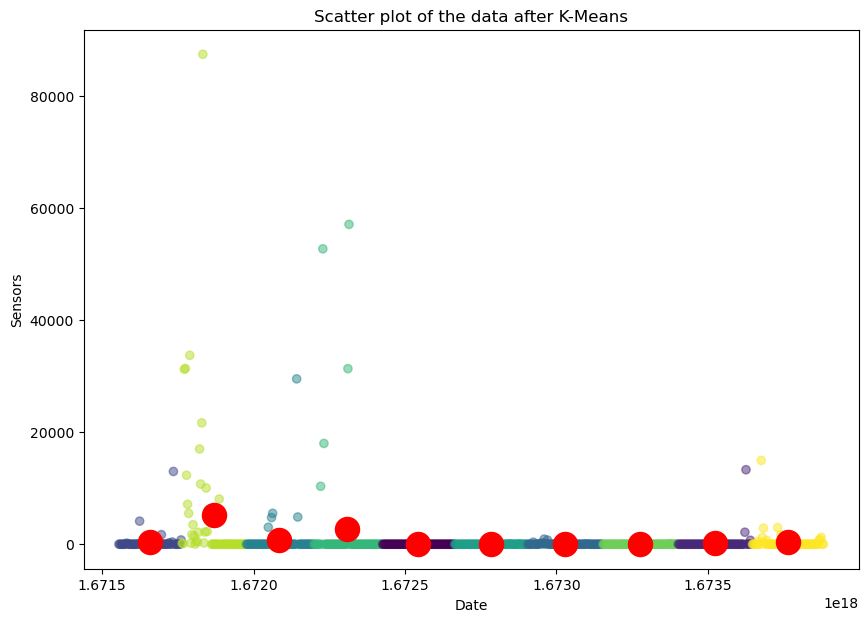

[1.02600003e+14 9.90000035e+13 9.54000008e+13 9.18000036e+13
 8.82000028e+13 8.46000047e+13 8.10000024e+13 7.73999954e+13
 7.37999950e+13 7.01999979e+13]


In [42]:
# k means clustering

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_hourly)

# Predict the cluster labels: labels
labels = kmeans.predict(df_hourly)
# print(labels)

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

plt.figure(figsize=(10,7))
plt.scatter(df_hourly['date'], df_hourly['Value'], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='red')
plt.title('Scatter plot of the data after K-Means')
plt.xlabel('Date')
plt.ylabel('Sensors')
plt.show()

# Compute the distances to the cluster centers
distances = kmeans.transform(df_hourly)

# Compute the anomaly score (distance to the closest centroid)
scores = distances.min(axis=1)

# Print the first 10 anomaly scores
print(scores[:10])



C:\Users\ASUS\AppData\Local\Temp\ipykernel_19628\4051798993.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Reds")


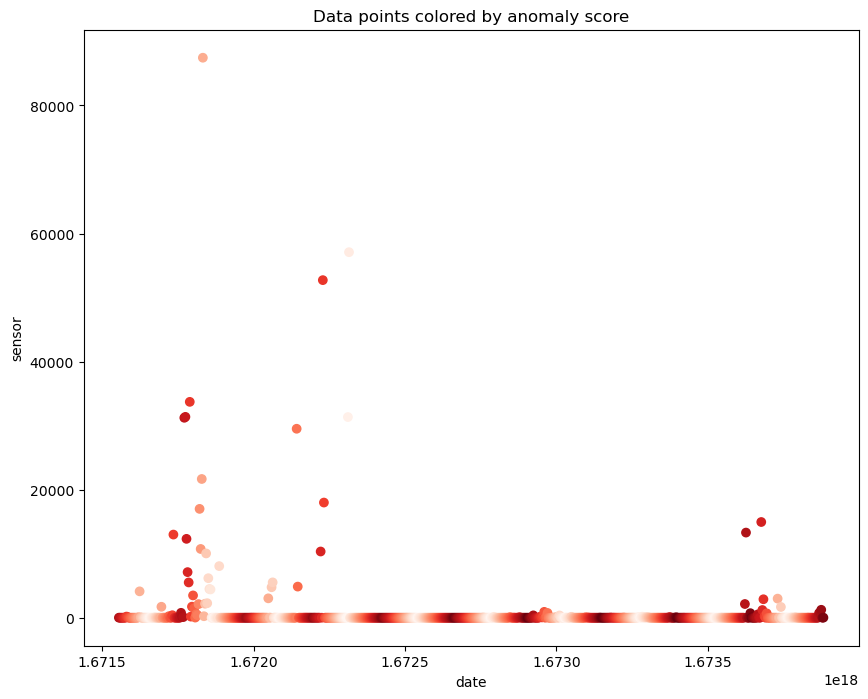

In [39]:
#Define the color map to convert scores to colors

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color map that maps scores to colors
cmap = cm.get_cmap("Reds")

# Normalize the scores to the range [0, 1] for color mapping
normalized_scores = (scores-min(scores)) / (max(scores)-min(scores))

# Create a scatter plot of the PCA-transformed data with points colored by anomaly score
plt.figure(figsize=(10, 8))
plt.scatter(df_hourly['date'], df_hourly['Value'], c=cmap(normalized_scores))
# plt.colorbar(label='Anomaly score')
plt.xlabel('date')
plt.ylabel('sensor')
plt.title('Data points colored by anomaly score')
plt.show()

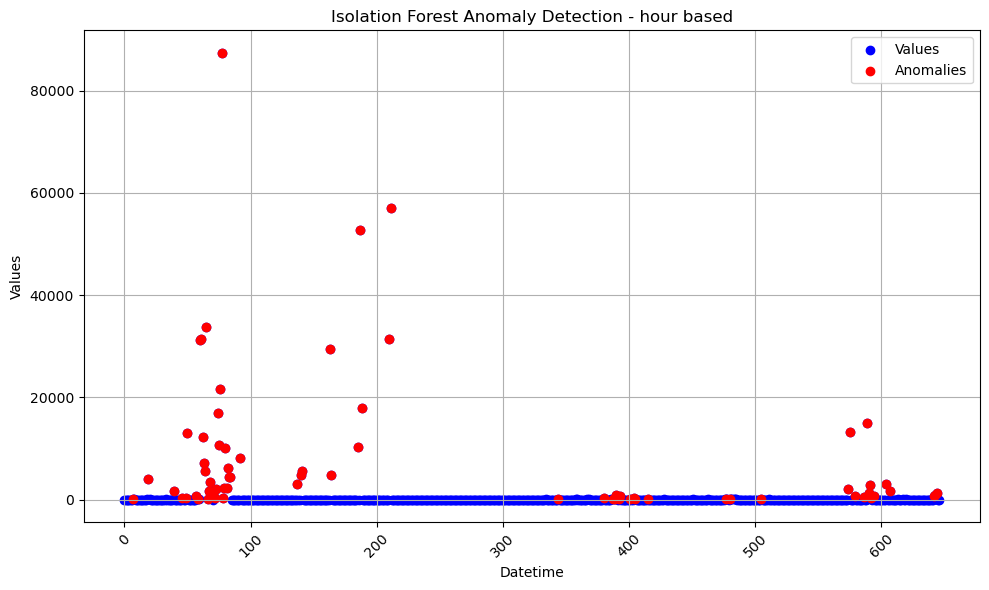

Total anomalies: 71, Percentage of anomalous values: 10.973724884080372%


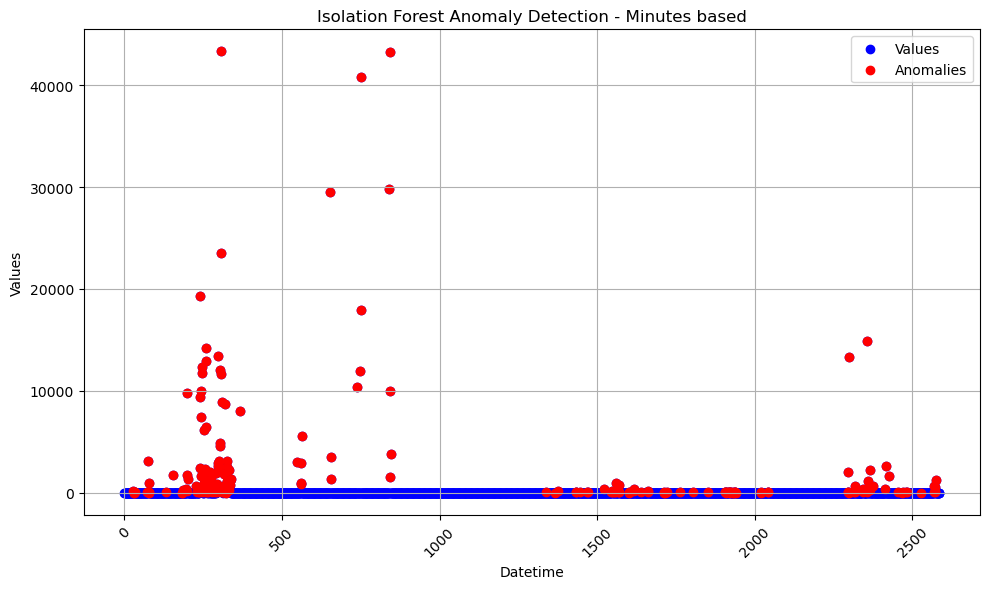

Total anomalies: 213, Percentage of anomalous values: 8.236658932714617%


In [12]:
# isolation forest
from sklearn.ensemble import IsolationForest

df_hourly['date'] = pd.to_datetime(df_hourly['date'])

# Prepare data for IsolationForest
values = df_hourly[['Value']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest( random_state=42)
df_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = df_hourly[df_hourly['anomaly'] == -1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df_hourly.index, df_hourly['Value'], label='Values', color='blue')
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies', marker='o')
plt.title('Isolation Forest Anomaly Detection - hour based')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the anomalies detected
# print(anomalies)
# Calculate the percentage of values equal to -1
count_anomaly_h = (df_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(df_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

# anomalies by minutes
df_minute['date'] = pd.to_datetime(df_minute['date'])

# Prepare data for IsolationForest
values_m = df_minute[['Value']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest( random_state=42)
df_minute['anomaly'] = model.fit_predict(values_m)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies_m = df_minute[df_minute['anomaly'] == -1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df_minute.index, df_minute['Value'], label='Values', color='blue')
plt.scatter(anomalies_m.index, anomalies_m['Value'], color='red', label='Anomalies', marker='o')
plt.title('Isolation Forest Anomaly Detection - Minutes based')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the anomalies detected
# print(anomalies_m)
# Calculate the percentage of values equal to -1
count_anomaly_m = (df_minute['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_m = (count_anomaly_m / len(df_minute)) * 100
print(f"Total anomalies: {count_anomaly_m}, Percentage of anomalous values: {percentage_m}%")
